In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [359]:
def get_clean_data(folder, name, salvo_qty):
    input_df = pd.read_csv(f'{folder}/{name}.csv', header=None, nrows=salvo_qty*5)

    before_len = len(input_df)
    
    print("Cleaning " + name + ".csv (" + str(before_len) + " rows)")
    
    allowed_http_codes = [200, 302]
    
    input_df = input_df[(input_df[1].isin(allowed_http_codes)) & (input_df[2].isin(allowed_http_codes))]
    print(str(before_len - len(input_df)) + " rows with unexpected http codes")

    before_len = len(input_df)
    input_df = input_df[(np.abs(stats.zscore(input_df[0])) < 3)]
    print(str(before_len - len(input_df)) + " rows with outliers")
    
    return input_df[0]

# NOTE no outlier removal etc - here we are trying to see how effective the most naive implemetantion would be. 
# I.e. how likely it is that an attack is accurate given a small sample of salvos (i.e. 5 pairs as the entire attack).  
def show_overall_result(folder, name, salvo_qty):
    input_df = pd.read_csv(f'{folder}/{name}.csv', header=None, nrows=salvo_qty)
    total_qty = len(input_df)
    suspect_email_exists_qty = len(input_df[input_df[0] == 0])

    pct = (suspect_email_exists_qty / total_qty) * 100
    
    print(f'{suspect_email_exists_qty} of {total_qty} ({pct}%) results indicate a user exists with the given email')

# Locations: local, remote
# Types: attack, control
def analyse_result_folder(folder, locations, types, salvo_qty=1000):
    df = pd.DataFrame()
    
    for type in types:
        for location in locations:
            print(f'\n{folder} {location} {type}') 
            
            name = f'{location}_{type}_detail'
            
            df[name] = get_clean_data(folder, name, salvo_qty)

            name = f'{location}_{type}_winners'
            
            show_overall_result(folder, name, salvo_qty)

    xlim=20e8
    
    df.plot(
        kind='kde', 
        # bw_method=0.1,
        figsize=(15,5), 
        color=['red', 'olivedrab', 'goldenrod', 'mediumseagreen'],
        xlim=(-xlim, xlim)
    )

In [360]:
# While the above kde chart is useful for improving our mental model of how the attack works, all a real attacker really needs to know is 
# whether responses typically arrived at about the same time. 
# Our analysis suggests that only one batch of 5 pairs is required, even in the remote (over the internet) context

# Suprised that the spread is wider for local vs. remote. Perhaps something to do with virtualisation, or some other detail of the specific
# deployment of the contrived target app. What's cool about this attack though, is that we don't care about that kind of detail at all! 
# All we care about is "did the response pairs arrive back at about the same time?". 

# As you would expect, remote probes take longer in general, vs. local


# What is most interesting in these results is how obvious the difference between control and attack is. 
# This suggests that any single indicator in the attack data of the target user existing is probably good enough
# Itis very likely that the first salvo will be enough, and if not, only 2 or 3 should be required nuder most circumstances. 


results_wifi_40ms_20ms local attack
Cleaning local_attack_detail.csv (250 rows)
0 rows with unexpected http codes
5 rows with outliers
33 of 50 (66.0%) results indicate a user exists with the given email

results_wifi_40ms_20ms local control
Cleaning local_control_detail.csv (245 rows)
0 rows with unexpected http codes
1 rows with outliers
20 of 49 (40.816326530612244%) results indicate a user exists with the given email


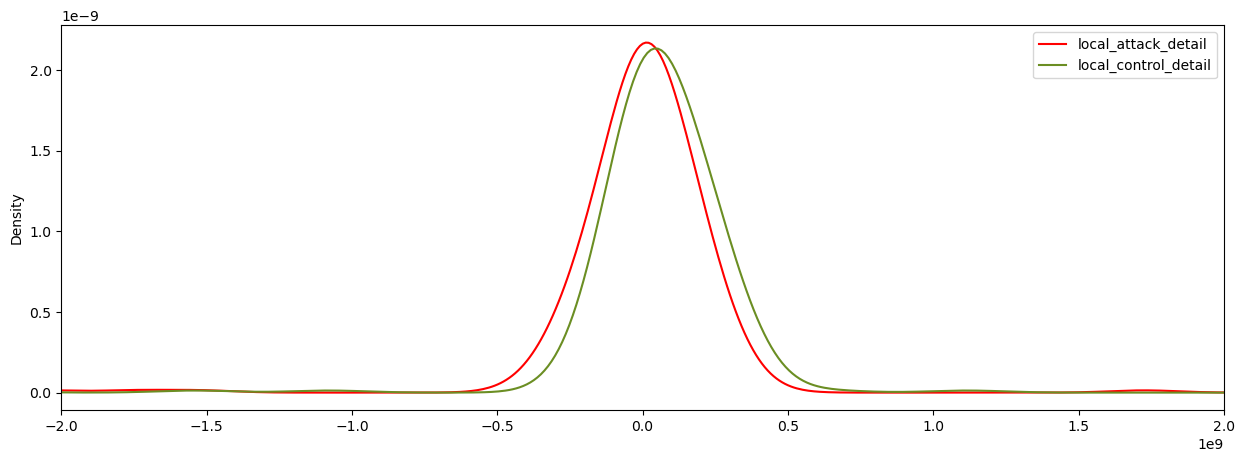

In [361]:
analyse_result_folder("results_wifi_40ms_20ms", ["local"], ["attack", "control"])


results_wifi_20ms_10ms local attack
Cleaning local_attack_detail.csv (305 rows)
0 rows with unexpected http codes
1 rows with outliers
45 of 61 (73.77049180327869%) results indicate a user exists with the given email

results_wifi_20ms_10ms local control
Cleaning local_control_detail.csv (265 rows)
0 rows with unexpected http codes
3 rows with outliers
23 of 53 (43.39622641509434%) results indicate a user exists with the given email


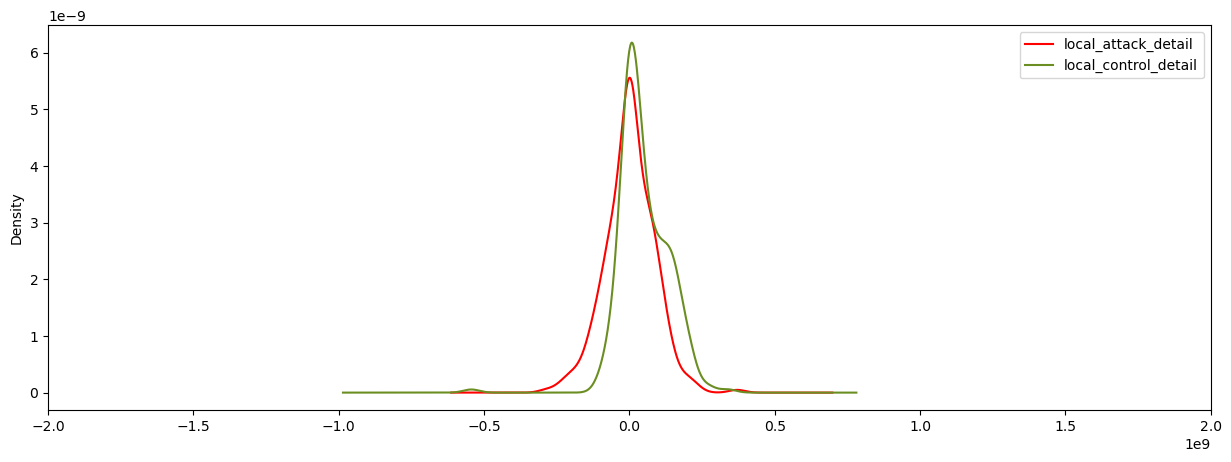

In [362]:
analyse_result_folder("results_wifi_20ms_10ms", ["local"], ["attack", "control"])


results_wifi_10ms_5ms local attack
Cleaning local_attack_detail.csv (565 rows)
0 rows with unexpected http codes
7 rows with outliers
64 of 113 (56.63716814159292%) results indicate a user exists with the given email

results_wifi_10ms_5ms local control
Cleaning local_control_detail.csv (295 rows)
0 rows with unexpected http codes
3 rows with outliers
4 of 59 (6.779661016949152%) results indicate a user exists with the given email


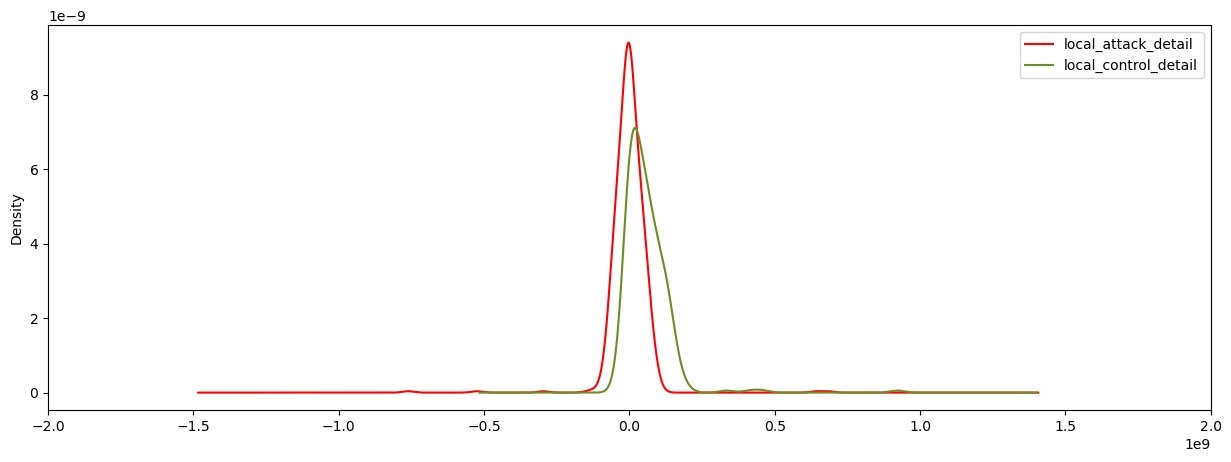

In [363]:
analyse_result_folder("results_wifi_10ms_5ms", ["local"], ["attack", "control"])


results_wifi_5ms_2.5ms local attack
Cleaning local_attack_detail.csv (240 rows)
0 rows with unexpected http codes
4 rows with outliers
26 of 48 (54.166666666666664%) results indicate a user exists with the given email

results_wifi_5ms_2.5ms local control
Cleaning local_control_detail.csv (250 rows)
0 rows with unexpected http codes
3 rows with outliers
0 of 50 (0.0%) results indicate a user exists with the given email


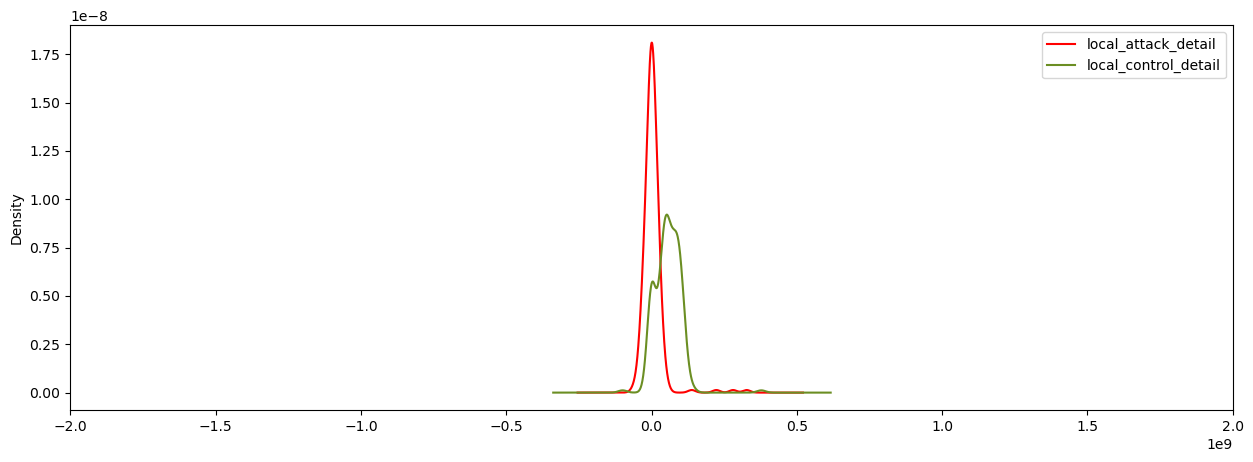

In [364]:
analyse_result_folder("results_wifi_5ms_2.5ms", ["local"], ["attack", "control"])



results_wifi_0ms_0ms local attack
Cleaning local_attack_detail.csv (574 rows)
0 rows with unexpected http codes
2 rows with outliers
70 of 115 (60.86956521739131%) results indicate a user exists with the given email

results_wifi_0ms_0ms local control
Cleaning local_control_detail.csv (490 rows)
0 rows with unexpected http codes
7 rows with outliers
0 of 98 (0.0%) results indicate a user exists with the given email


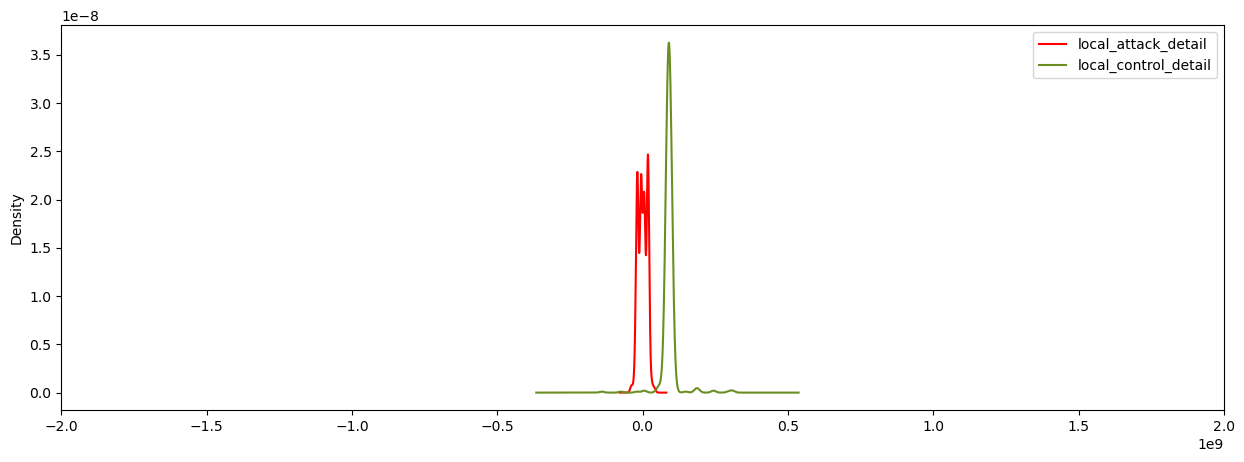

In [365]:
analyse_result_folder("results_wifi_0ms_0ms", ["local"], ["attack", "control"])


results_wifi_20ms_10ms_randomised local attack
Cleaning local_attack_detail.csv (375 rows)
0 rows with unexpected http codes
2 rows with outliers
42 of 75 (56.00000000000001%) results indicate a user exists with the given email

results_wifi_20ms_10ms_randomised local control
Cleaning local_control_detail.csv (295 rows)
0 rows with unexpected http codes
1 rows with outliers
2 of 59 (3.389830508474576%) results indicate a user exists with the given email


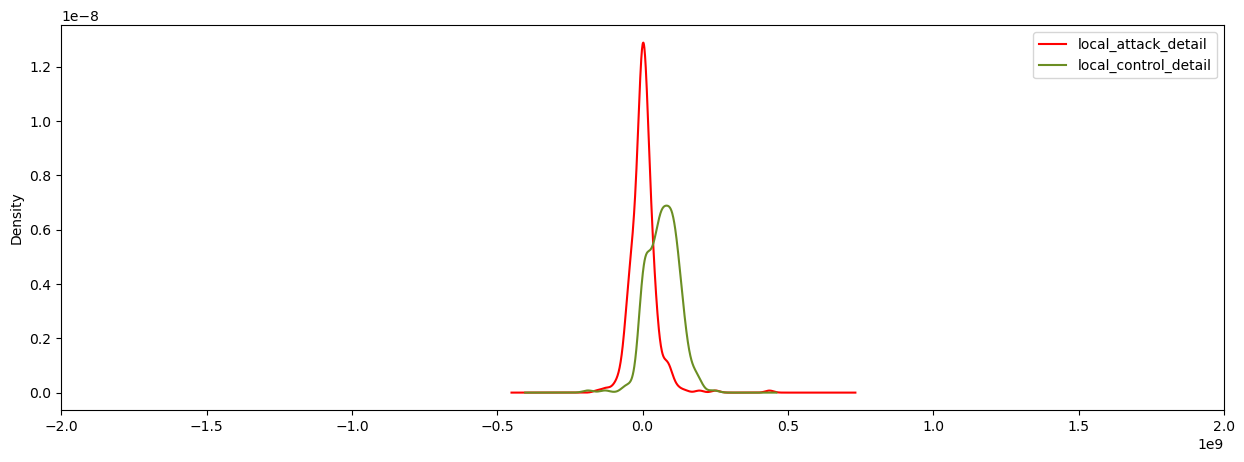

In [366]:
analyse_result_folder("results_wifi_20ms_10ms_randomised", ["local"], ["attack", "control"])


results_wifi_40ms_20ms_randomised local attack
Cleaning local_attack_detail.csv (250 rows)
0 rows with unexpected http codes
5 rows with outliers
25 of 50 (50.0%) results indicate a user exists with the given email

results_wifi_40ms_20ms_randomised local control
Cleaning local_control_detail.csv (1190 rows)
0 rows with unexpected http codes
12 rows with outliers
50 of 238 (21.008403361344538%) results indicate a user exists with the given email


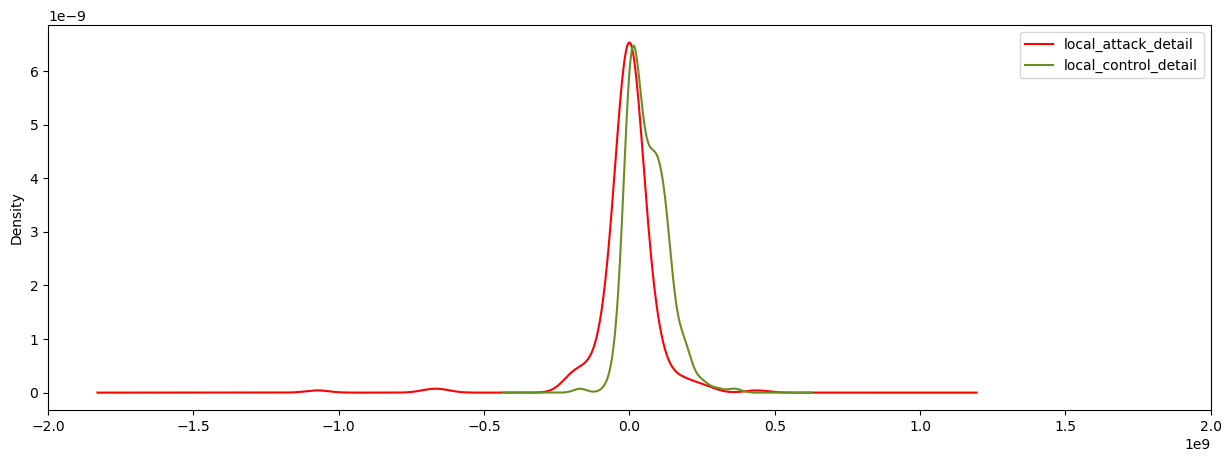

In [367]:
analyse_result_folder("results_wifi_40ms_20ms_randomised", ["local"], ["attack", "control"])


results_sequential_wifi_0ms_0ms local attack
Cleaning local_attack_detail.csv (280 rows)
0 rows with unexpected http codes
7 rows with outliers
34 of 56 (60.71428571428571%) results indicate a user exists with the given email

results_sequential_wifi_0ms_0ms local control
Cleaning local_control_detail.csv (555 rows)
0 rows with unexpected http codes
14 rows with outliers
1 of 111 (0.9009009009009009%) results indicate a user exists with the given email


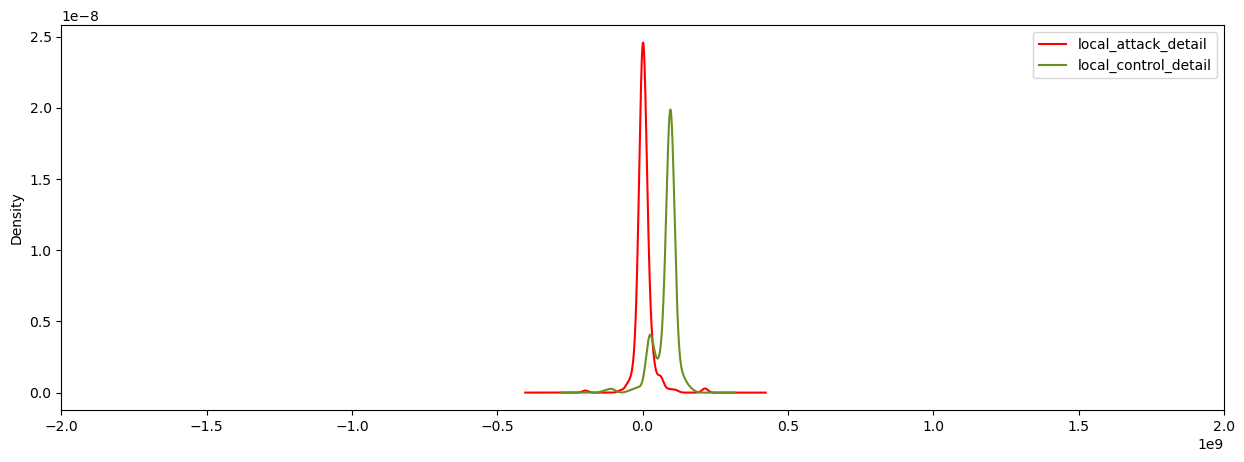

In [368]:
analyse_result_folder("results_sequential_wifi_0ms_0ms", ["local"], ["attack", "control"])


results_sequential_wifi_40ms_20ms_randomised local attack
Cleaning local_attack_detail.csv (250 rows)
0 rows with unexpected http codes
1 rows with outliers
27 of 50 (54.0%) results indicate a user exists with the given email

results_sequential_wifi_40ms_20ms_randomised local control
Cleaning local_control_detail.csv (395 rows)
0 rows with unexpected http codes
10 rows with outliers
50 of 79 (63.29113924050633%) results indicate a user exists with the given email


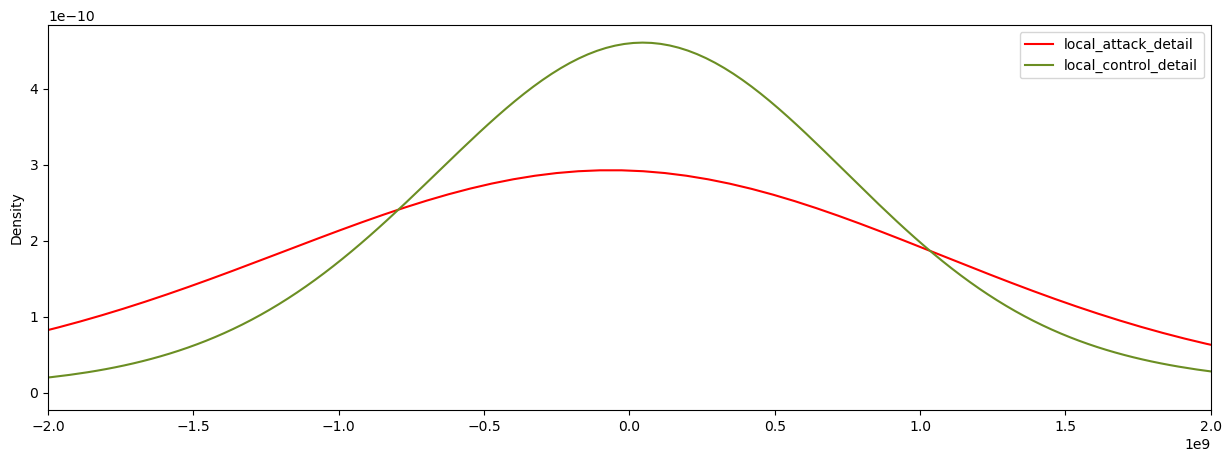

In [374]:
analyse_result_folder("results_sequential_wifi_40ms_20ms_randomised", ["local"], ["attack", "control"])

In [387]:
analyse_result_folder("results", ["local"], ["attack", "control"])


results local attack


FileNotFoundError: [Errno 2] No such file or directory: 'results/local_attack_detail.csv'